In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score, \
precision_recall_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
master_df = pd.read_csv('core/master.csv')
awards_df = pd.read_csv('core/AwardsPlayers.csv')
batting_df = pd.read_csv('core/Batting.csv')
field_df = pd.read_csv('core/Fielding.csv')
allstar_df = pd.read_csv('core/AllStarFull.csv')
salary_df = pd.read_csv('core/Salaries.csv')

In [3]:
gg_df = awards_df[awards_df.awardID=='Gold Glove']

In [4]:
#stats_df = pd.concat([batting_df, field_df], axis=1)#join_axes=['yearID', 'playerID'])
stats_df = pd.merge(batting_df, field_df, on=['playerID', 'yearID'])

In [5]:
stats_df = stats_df[stats_df['yearID']>1956]

In [6]:
# create a dictionary that gives the salary corresponding year and player
combi_salary = {}
for year, player, salary in zip(salary_df['yearID'], salary_df['playerID'], salary_df['salary']):
    combi_salary[(year, player)] = salary

In [7]:
def get_salary(row):

    try:
        return combi_salary[(row['yearID'], row['playerID'])]
    except KeyError:
        return np.nan

stats_df['salary'] = stats_df.apply(get_salary, axis = 1)

In [8]:
# create a dictionary that gives the all start position corresponding year and player
combi_allstar = {}
for year, player, pos in zip(allstar_df['yearID'], allstar_df['playerID'], allstar_df['startingPos']):
        combi_allstar[(year, player)] = 1

In [9]:
def get_allstar(row):

    try:
        return combi_allstar[(row['yearID'], row['playerID'])]
    except KeyError:
        return 0

In [10]:
stats_df['allstar'] = stats_df.apply(get_allstar, axis = 1)

In [11]:
# create a dictionary that gives the position corresponding year and player
combi_gg = {}
for year, player, notes in zip(gg_df['yearID'], gg_df['playerID'], gg_df['notes']):
        combi_gg[(year, player)] = notes

In [12]:
def get_position(row):

    try:
        return combi_gg[(row['yearID'], row['playerID'])]
    except KeyError:
        return 0


In [13]:
stats_df['GG'] = stats_df.apply(get_position, axis = 1)

In [14]:
def get_previous(row):

    try:
        i = 1
        num = 0
        while combi_gg.get((row['yearID']-i, row['playerID']), False):
            num += 1    
            i += 1
            
        return num            
    
    except KeyError:
        return 0

In [15]:
stats_df['previous'] = stats_df.apply(get_previous, axis = 1)

In [16]:
stats_wona_df = stats_df.apply(lambda x : x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [17]:
stats_wona_df = stats_wona_df.drop(['lgID_x', 'lgID_y', 'playerID', 'teamID_x', 'teamID_y'], axis=1)

# Specify the position to be predicted

In [18]:
positions = {
    'P':['P', 1],
    'C':['C', 2],
    '1B':['1B', 3],
    '2B':['2B', 4],
    '3B':['3B', 5],
    'SS':['SS', 6],
    'OF':['OF', 'LF', 'CF', 'RF', 7, 8, 9]
}

In [19]:
position = 'OF'

In [20]:
if position != 'OF':    
    stats_OF_df = stats_wona_df[stats_wona_df['POS'] == positions[position][0]]
    stats_OF_df.loc[stats_OF_df['GG'] != positions[position][0], 'GG'] = 0
    stats_OF_df.loc[stats_OF_df['GG'] == positions[position][0], 'GG'] = 1
else:
    stats_OF_df = stats_wona_df[(stats_wona_df['POS'] == 'OF') | (stats_wona_df['POS'] == 'CF') | 
                                (stats_wona_df['POS'] == 'RF') | (stats_wona_df['POS'] == 'LF')]

    stats_OF_df.loc[(stats_OF_df['GG'] == 'OF') | (stats_OF_df['GG'] == 'RF') | 
                    (stats_OF_df['GG'] == 'CF') | (stats_OF_df['GG'] == 'LF'), 'GG'] = 1
    stats_OF_df.loc[(stats_OF_df['GG'] != 1), 'GG'] = 0

C:\Users\the_b\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
X = stats_OF_df.drop(['GG', 'POS'], axis=1)
y = list(stats_OF_df['GG'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(confusion_matrix(y_test, predicted))
predicted_train = model.predict(X_train)
print(confusion_matrix(y_train, predicted_train))
target_names = (['0','1'])
print(classification_report(y_test,
                            predicted,
                            target_names=target_names))
print(accuracy_score(y_test, predicted))

[[3670   35]
 [  36   40]]
[[14830     0]
 [    0   292]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3705
          1       0.53      0.53      0.53        76

avg / total       0.98      0.98      0.98      3781

0.981221898969


In [22]:
rf_model = RandomForestClassifier()

tuned_parameters = [{'n_estimators': [50,100,300], 'min_samples_leaf': [1, 5],
                     'max_features': ['auto']}]

clf = GridSearchCV(rf_model, tuned_parameters)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(confusion_matrix(y_test, predicted))
predicted_train = clf.predict(X_train)
print(confusion_matrix(y_train, predicted_train))
target_names = (['0','1'])
print(classification_report(y_test,
                            predicted,
                            target_names=target_names))
print(accuracy_score(y_test, predicted))
print(clf.best_estimator_)

[[3699    6]
 [  50   26]]
[[14830     0]
 [    0   292]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3705
          1       0.81      0.34      0.48        76

avg / total       0.98      0.99      0.98      3781

0.985189103412
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [23]:
gb_model = GradientBoostingClassifier()

tuned_parameters2 = [{'n_estimators': [50,100,300], 'min_samples_leaf': [1, 10],
                     'max_features': ['auto', 'log2']}]

clf2 = GridSearchCV(gb_model, tuned_parameters2)
clf2.fit(X_train, y_train)
predicted = clf2.predict(X_test)
print(confusion_matrix(y_test, predicted))
predicted_train = clf2.predict(X_train)
print(confusion_matrix(y_train, predicted_train))
target_names = (['0','1'])
print(classification_report(y_test,
                            predicted,
                            target_names=target_names))
print(accuracy_score(y_test, predicted))
print(clf2.best_estimator_)

[[3699    6]
 [  39   37]]
[[14806    24]
 [  137   155]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3705
          1       0.86      0.49      0.62        76

avg / total       0.99      0.99      0.99      3781

0.98809838667
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


In [24]:
y_pred_probs = clf2.predict_proba(X_test)
print('Some example probabilities:', y_pred_probs[:10])

# y_pred_probs contains probabilities for both '1' and '0'. we only
# care about the probabilities of '1', so we extract it below.
high_index = clf2.best_estimator_.classes_.tolist().index(1) # this '1' corresponds to what you want to return
y_high_probs = [y_pred_probs[i, high_index] for i in range(y_pred_probs.shape[0])]

print("Just the '1' probabilities:", y_high_probs[:10])

Some example probabilities: [[ 0.99852208  0.00147792]
 [ 0.83193289  0.16806711]
 [ 0.99852208  0.00147792]
 [ 0.99852208  0.00147792]
 [ 0.98667278  0.01332722]
 [ 0.99524996  0.00475004]
 [ 0.99852208  0.00147792]
 [ 0.99852208  0.00147792]
 [ 0.99852208  0.00147792]
 [ 0.99852208  0.00147792]]
Just the '1' probabilities: [0.001477915421375943, 0.16806710804523059, 0.001477915421375943, 0.001477915421375943, 0.013327221295252564, 0.0047500355803539512, 0.001477915421375943, 0.001477915421375943, 0.001477915421375943, 0.001477915421375943]


Average precision is 0.669222710987


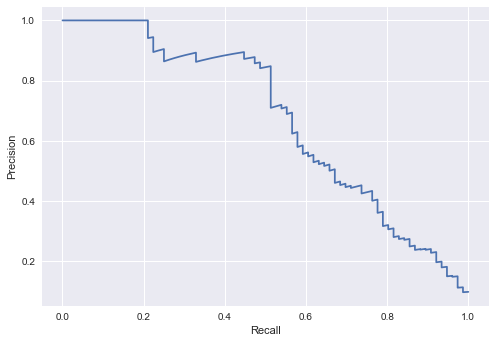

In [25]:
average_precision = average_precision_score (y_test, y_high_probs)
precisions, recalls, _ = precision_recall_curve(y_test, y_high_probs)
#print(precision_recall_curve(y_test, y_high_probs))
print('Average precision is', average_precision)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [26]:
features_importances = list(zip(X.columns, model.feature_importances_))
features_importances.sort(key=lambda x:x[1], reverse=True)
features_importances[:10]

[('previous', 0.26775210674192046),
 ('GS', 0.1117245370417289),
 ('PO', 0.055877018530518033),
 ('R', 0.04781553126419566),
 ('H', 0.042543660516850976),
 ('InnOuts', 0.037177793393612601),
 ('HR', 0.035548099345162884),
 ('RBI', 0.034501904281978822),
 ('SB_x', 0.029521657674997627),
 ('E', 0.027339051391465422)]

In [27]:
features_importances = list(zip(X.columns, clf.best_estimator_.feature_importances_))
features_importances.sort(key=lambda x:x[1], reverse=True)
features_importances[:10]

[('previous', 0.1727300783117022),
 ('PO', 0.08400907491476603),
 ('InnOuts', 0.048342262790674079),
 ('R', 0.042428648018490389),
 ('H', 0.04089932619516691),
 ('G_y', 0.040577326962501041),
 ('GS', 0.040532145830030321),
 ('A', 0.034394038284205085),
 ('AB', 0.033972016131707854),
 ('yearID', 0.030575778708401734)]

In [28]:
features_importances = list(zip(X.columns, clf2.best_estimator_.feature_importances_))
features_importances.sort(key=lambda x:x[1], reverse=True)
features_importances[:10]

[('previous', 0.22565640887907329),
 ('PO', 0.11674065951571472),
 ('GS', 0.086552539440284182),
 ('E', 0.057712663712584315),
 ('A', 0.051099632712700974),
 ('R', 0.050566431008162036),
 ('G_x', 0.037955163203225464),
 ('InnOuts', 0.037871280974254844),
 ('HR', 0.032300146225573687),
 ('G_y', 0.032219304088437047)]

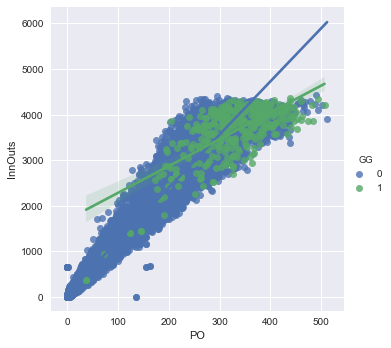

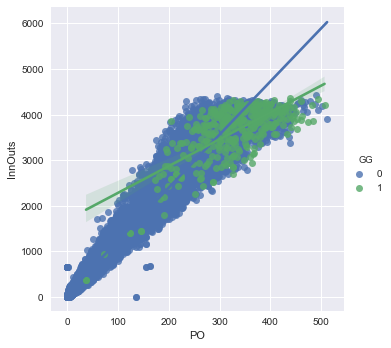

In [37]:
sns.set()

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="PO", y="InnOuts", hue="GG",
               truncate=True, size=5, data=stats_OF_df)

# Use more informative axis labels than are provided by default
g.set_axis_labels("PO", "InnOuts")
g.savefig('GG.png')
sns.plt.show()

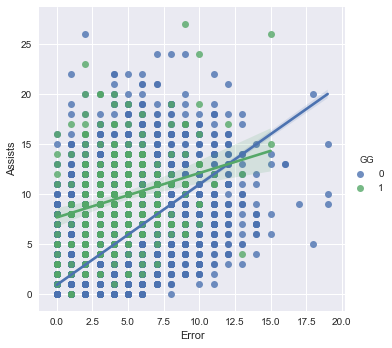

In [40]:
sns.set()

# Plot tip as a function of toal bill across days
f = sns.lmplot(x="E", y="A", hue="GG",
               truncate=True, size=5, data=stats_OF_df)

# Use more informative axis labels than are provided by default
f.set_axis_labels("Error", "Assists")
f.savefig('GG2.png')
sns.plt.show()

correlation  
factorplot kind=count  
countplot

In [30]:
stats_OF_df['GG'].value_counts(dropna=False)
stats_OF_df['allstar'].value_counts()

0    17764
1     1139
Name: allstar, dtype: int64

In [31]:
stats_OF_df.columns.values

array(['yearID', 'stint_x', 'G_x', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB_x', 'CS_x', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'stint_y', 'POS', 'G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP',
       'PB', 'WP', 'SB_y', 'CS_y', 'ZR', 'salary', 'allstar', 'GG',
       'previous'], dtype=object)

In [32]:
#stats_OF_df.corrwith(stats_OF_df['GG'], axis=1)

In [33]:
corr_df = stats_OF_df.drop(['POS'], axis=1).corr()

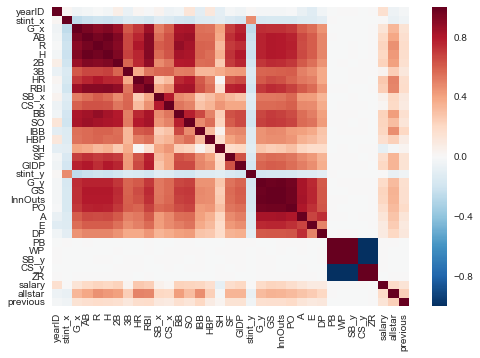

In [34]:
sns.set()

# Draw a heatmap
my_plot = sns.heatmap(corr_df)
my_plot.get_figure().savefig('heatmap.png')
sns.plt.show()

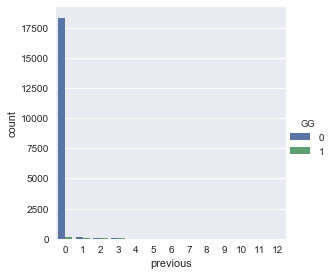

In [35]:
g = sns.factorplot(x='previous', hue="GG",
                  data=stats_OF_df,
                  kind="count")
sns.plt.show()

threshold 6people each year